# Build regression models

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

d = './raw_data/'

In [2]:
# Import data
with open('processed_data/train_build.pkl', 'rb') as filename:  
    processed_data = pickle.load(filename)

In [32]:
predictors = ['log_adjusted_budget', 'avg_wroi_similar_overview',
              'avg_wroi_director_id_1',
              'avg_wroi_actor_id_1', 'avg_wroi_actor_id_2', 'avg_wroi_actor_id_3',
              'avg_wroi_genre_name_1', 'avg_wroi_genre_name_2', 'avg_wroi_genre_name_3', 
              'avg_wroi_production_company_1','avg_wroi_production_company_2', 'avg_wroi_production_company_3',
              'avg_rating_director_id_1',
              'avg_rating_actor_id_1', 'avg_rating_actor_id_2', 'avg_rating_actor_id_3',
              'avg_rating_genre_name_1', 'avg_rating_genre_name_2','avg_rating_genre_name_3', 
              'avg_rating_production_company_1','avg_rating_production_company_2', 'avg_rating_production_company_3',
              'avg_wroi_top_cast_id', 'avg_wroi_genres_list', 'avg_wroi_top_production_companies', 
              'avg_rating_top_cast_id',	'avg_rating_genres_list', 'avg_rating_top_production_companies'
             ]
outputs = ['log_wroi']

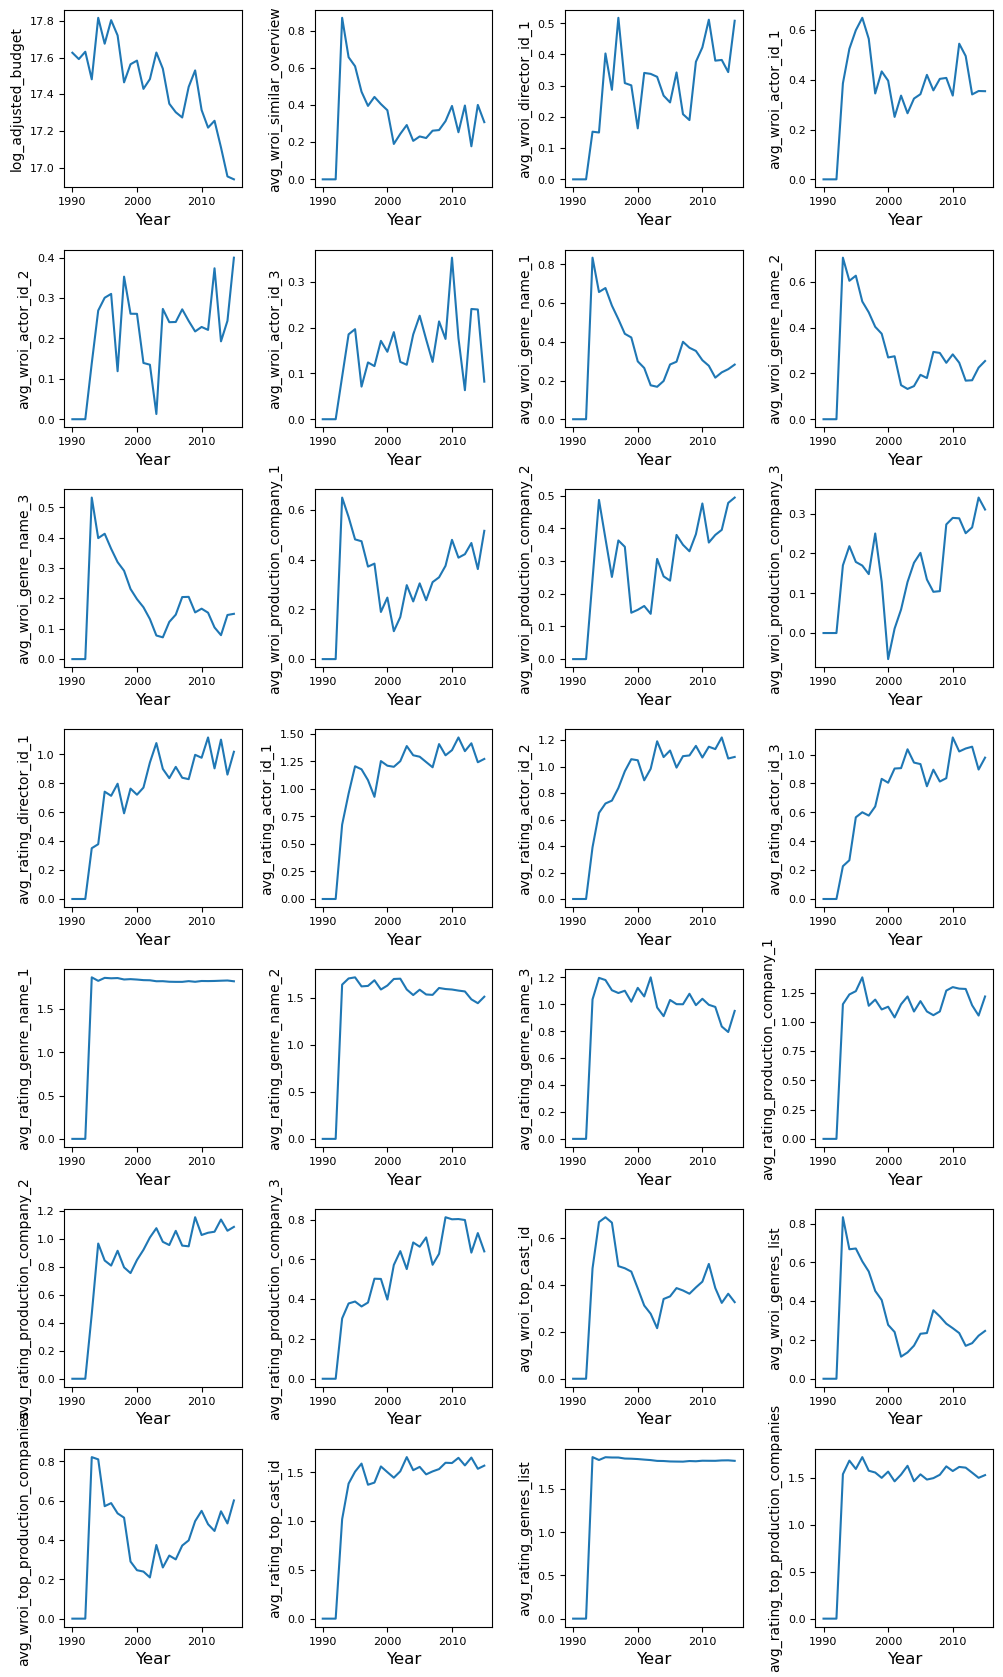

In [33]:
# Inspect distribution of observables
select_vars = predictors

fig, axs = plt.subplots(len(select_vars) // 4, 4, figsize=(3*4, 3*len(select_vars) // 4), sharex=False, sharey=False)
input_data = processed_data[select_vars + ['year']].groupby(['year'], as_index = False).mean()

for i, ax in enumerate(axs.flat):
    if i < len(select_vars):
        ax.plot(input_data['year'], input_data[select_vars[i]]);
        ax.minorticks_off()
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_box_aspect(1)
        ax.set_ylabel(select_vars[i], fontsize = 10)
        ax.set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

KeyError: "['log_wroi'] not in index"

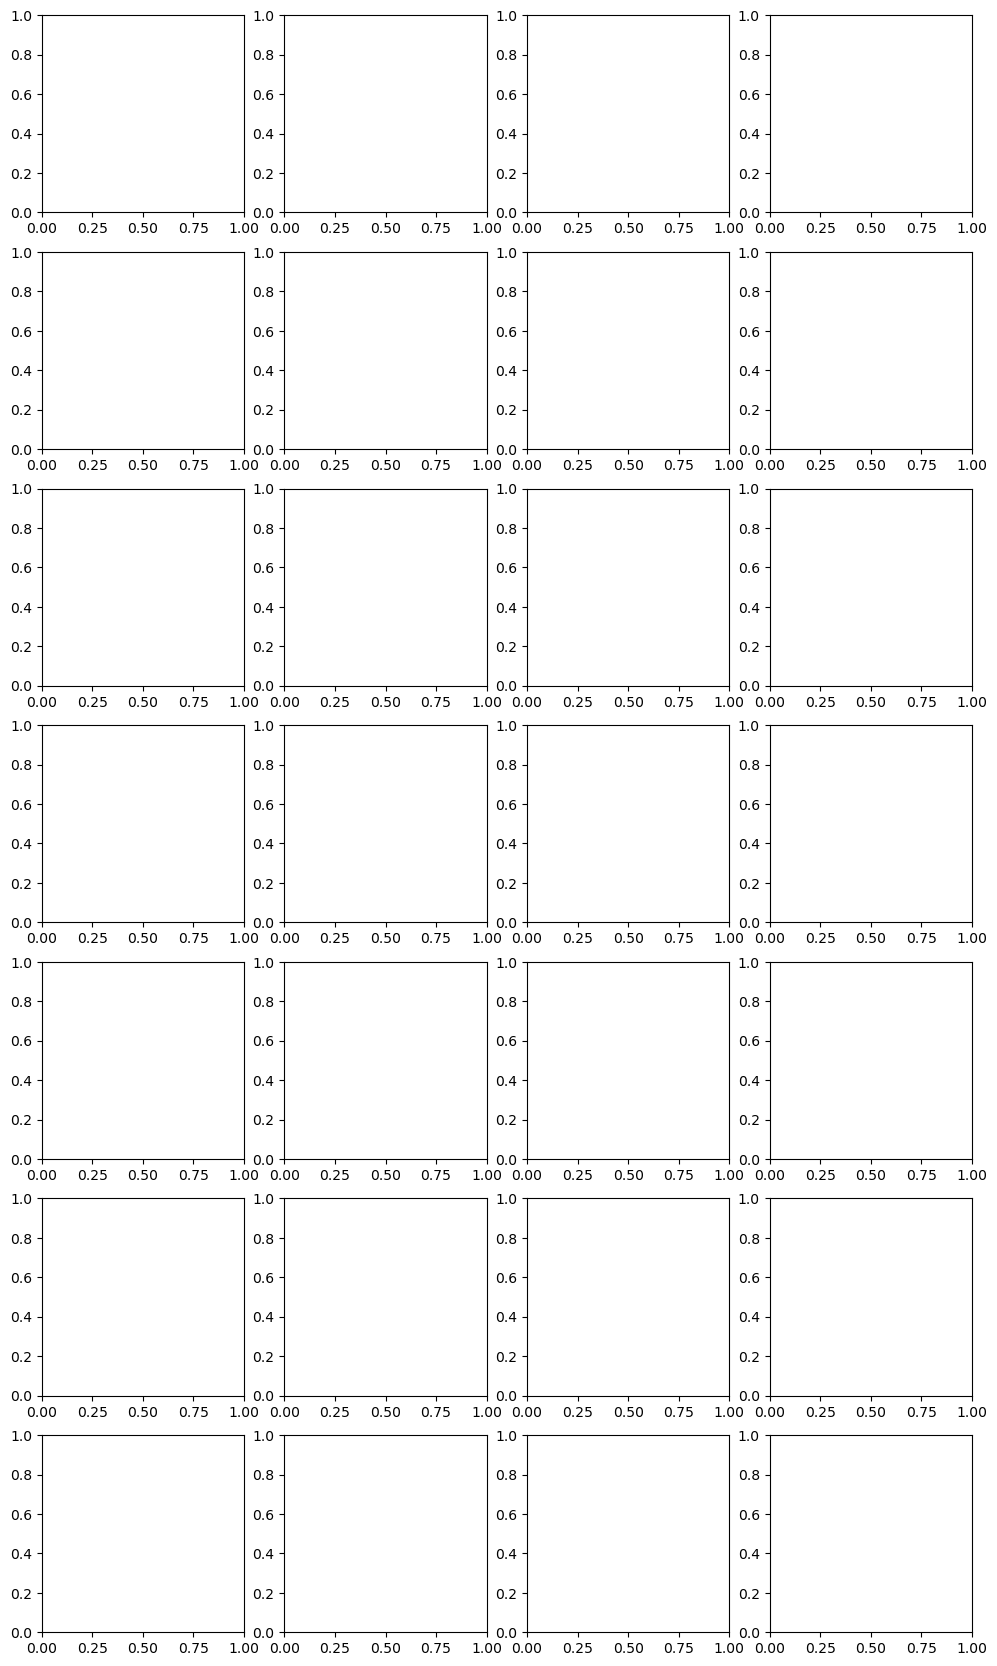

In [34]:
# Inspect distribution of observables
select_vars = predictors

fig, axs = plt.subplots(len(select_vars) // 4, 4, figsize=(3*4, 3*len(select_vars) // 4), sharex=False, sharey=False)
input_data = processed_data[select_vars + ['year'] + outputs]

for i, ax in enumerate(axs.flat):
    if i < len(select_vars):
        ax.scatter(input_data[select_vars[i]], input_data[outputs]);
        ax.minorticks_off()
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_box_aspect(1)
        ax.set_ylabel('Log WROI', fontsize = 10)
        ax.set_xlabel(select_vars[i], fontsize = 10)

fig.subplots_adjust(wspace=.4, hspace=.5)

Need to scale variables, and figure out how to measure performance.

#### Linear regression

Year: 2000.0 RMSE: 1.7652723957845906 Score: -0.08149509056935633
Year: 2001.0 RMSE: 2.08251498269179 Score: 0.027915768371758132
Year: 2002.0 RMSE: 1.7614553547770682 Score: -0.07903099844423012
Year: 2003.0 RMSE: 2.2196055698584747 Score: -0.0040871767189982755
Year: 2004.0 RMSE: 2.587969895725052 Score: 0.04123763423839688
Year: 2005.0 RMSE: 2.5025352254837463 Score: 0.12123782513814674
Year: 2006.0 RMSE: 2.514864261987659 Score: 0.07796713249468634
Year: 2007.0 RMSE: 2.271901473057157 Score: -0.00558436576795418
Year: 2008.0 RMSE: 2.5012292225517037 Score: 0.05119539949023333
Year: 2009.0 RMSE: 2.5780031987945327 Score: 0.13818313233668977
Year: 2010.0 RMSE: 2.142533532192437 Score: 0.18100045713698376
Year: 2011.0 RMSE: 2.4364665196362023 Score: 0.1474343975022706
Year: 2012.0 RMSE: 2.4922511903329934 Score: 0.12048659039573928
Year: 2013.0 RMSE: 3.1282961716744073 Score: 0.20507366303875196
Year: 2014.0 RMSE: 3.52760954441862 Score: 0.09817077323895984


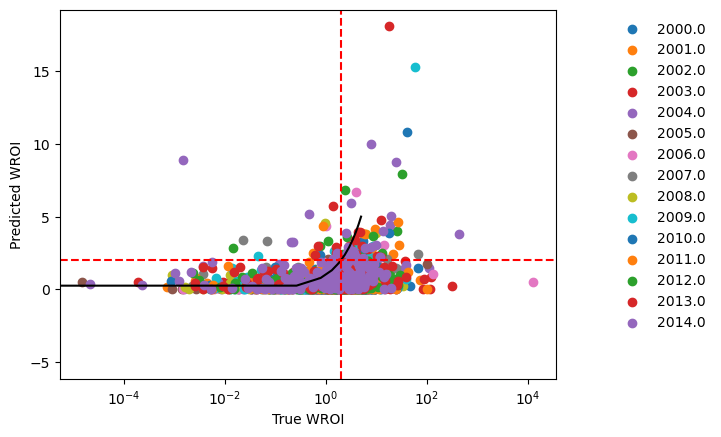

In [31]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5]
years = np.unique(processed_data.loc[processed_data.year >= 2000].year)
store_alphas = []

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    val_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    val_predictors_scaled = scaler.transform(val_data[predictors].to_numpy())
    # Run regression
    coefs = np.zeros((len(alphas), len(predictors) + 4))
    for i in range(len(alphas)):
        ## make lasso model
        lr = linear_model.Lasso(alpha=alphas[i], max_iter=10000000)
        ## record coefs
        lr.fit(train_predictors_scaled, np.log2(train_data[outputs]))
        coefs[i,0:len(predictors)] = lr.coef_
        # Compute score
        val_prediction = lr.predict(val_predictors_scaled)**2
        rmse = np.sqrt(mean_squared_error(np.log2(val_data[outputs]), val_prediction))
        score = lr.score(val_predictors_scaled, np.log2(val_data[outputs]))
        coefs[i,-4] = rmse
        coefs[i,-3] = score
        coefs[i,-2] = year
        coefs[i,-1] = alphas[i]

        # Visualize performance
        if i == 0:
            print("Year:", year, "RMSE:", rmse, "Score:", score)
            plt.scatter(val_data[outputs], val_prediction, label = str(year))
    #  Store data
    store_alphas.append(coefs)

plt.plot(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.semilogx()
plt.axhline(y = 2.0, linestyle = '--', color = 'red')
plt.axvline(x = 2.0, linestyle = '--', color = 'red')
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 1)

In [8]:
# Model selection
## use dataframe to look at coefs
df = pd.DataFrame(data=np.vstack(store_alphas), 
                  columns=predictors + ['rmse', 'score', 'year', 'alpha']).groupby('alpha', as_index = True).mean()
df

,log_adjusted_budget,avg_wroi_similar_overview,avg_wroi_director_id_1,avg_wroi_actor_id_1,avg_wroi_actor_id_2,avg_wroi_actor_id_3,avg_wroi_genre_name_1,avg_wroi_genre_name_2,avg_wroi_genre_name_3,avg_wroi_production_company_1,...,avg_rating_production_company_3,avg_wroi_top_cast_id,avg_wroi_genres_list,avg_wroi_top_production_companies,avg_rating_top_cast_id,avg_rating_genres_list,avg_rating_top_production_companies,rmse,score,year
alpha,,,,,,,,,,,,,,,,,,,,,
0.000001,-0.185381,0.092903,0.049984,-0.029959,-0.052541,0.043731,0.234800,0.157814,-0.026528,0.120650,...,0.010061,0.029610,-0.250674,0.026093,-0.278493,0.548149,0.333910,2.304868,0.069314,2007.0
0.000010,-0.185384,0.092899,0.049986,-0.029910,-0.052511,0.043731,0.234645,0.157733,-0.026532,0.120629,...,0.010070,0.029554,-0.250488,0.026096,-0.278387,0.541676,0.333914,2.304850,0.069331,2007.0
0.000100,-0.185405,0.092860,0.050013,-0.029414,-0.052206,0.043734,0.233098,0.156921,-0.026575,0.120420,...,0.010159,0.028996,-0.248631,0.026119,-0.277324,0.476951,0.333957,2.304677,0.069496,2007.0
0.001000,-0.183888,0.092109,0.049884,-0.024427,-0.049177,0.044306,0.221732,0.150280,-0.026051,0.118815,...,0.011124,0.023445,-0.235068,0.026457,-0.268399,0.058538,0.333172,2.303420,0.070722,2007.0
0.010000,-0.147027,0.080674,0.041372,-0.001616,-0.029756,0.042891,0.159271,0.102636,-0.008514,0.110022,...,0.017170,0.001933,-0.165032,0.030118,-0.211965,-0.080878,0.313282,2.301941,0.072763,2007.0
0.100000,0.000000,0.000000,0.001661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053745,...,0.000019,0.000000,0.000000,0.043831,-0.032128,-0.114873,0.166501,2.339854,0.045078,2007.0
0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003341,...,0.000000,0.000000,0.000000,0.020406,0.000000,0.000000,0.025400,2.396112,0.003240,2007.0
0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.411344,-0.007463,2007.0
0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.411344,-0.007463,2007.0


In [9]:
# This shows the first value of alpha where the parameter for the feature was set to zero.
df[predictors].ne(0).idxmin().sort_values(ascending=False)

avg_rating_top_production_companies    0.50
avg_rating_genre_name_1                0.50
avg_wroi_top_production_companies      0.50
avg_wroi_production_company_1          0.50
avg_wroi_director_id_1                 0.25
avg_rating_genres_list                 0.25
avg_rating_top_cast_id                 0.25
avg_rating_production_company_3        0.25
avg_wroi_production_company_2          0.25
avg_wroi_production_company_3          0.25
avg_rating_production_company_2        0.25
avg_rating_production_company_1        0.25
avg_wroi_genres_list                   0.10
avg_wroi_top_cast_id                   0.10
avg_rating_genre_name_3                0.10
avg_rating_genre_name_2                0.10
log_adjusted_budget                    0.10
avg_rating_actor_id_3                  0.10
avg_wroi_similar_overview              0.10
avg_rating_actor_id_1                  0.10
avg_rating_director_id_1               0.10
avg_wroi_genre_name_3                  0.10
avg_wroi_genre_name_2           

In [10]:
# Need to figure out which covariates are most important -> feature selection ala Lasso
# Build content-based covariate
# Include keywords and attempt similarity matching: ROI**(similarity score)

### KNN regression

Year: 2000.0 RMSE: 1.8404585463390903 Score: -0.08218316549773852
Year: 2001.0 RMSE: 2.090832273440826 Score: -0.00066631613146928
Year: 2002.0 RMSE: 1.8114627788182152 Score: -0.07340478368821768
Year: 2003.0 RMSE: 2.168777516413437 Score: -0.018495736101062255
Year: 2004.0 RMSE: 2.593486063418089 Score: 0.03746605900495281
Year: 2005.0 RMSE: 2.435724147331456 Score: 0.1042768424551499
Year: 2006.0 RMSE: 2.401748461080484 Score: 0.08990125969544294
Year: 2007.0 RMSE: 2.195473849669465 Score: 0.012076662249455472
Year: 2008.0 RMSE: 2.4194414672258167 Score: 0.08017218905477275
Year: 2009.0 RMSE: 2.323674116893428 Score: 0.15929835460223218
Year: 2010.0 RMSE: 2.013000412077284 Score: 0.1414152658915815
Year: 2011.0 RMSE: 2.3559889902044198 Score: 0.09940968045134735
Year: 2012.0 RMSE: 2.281146556691023 Score: 0.12354968079521933
Year: 2013.0 RMSE: 2.598466353235729 Score: 0.22414133564045613
Year: 2014.0 RMSE: 3.0648831349720846 Score: 0.11033952583826478


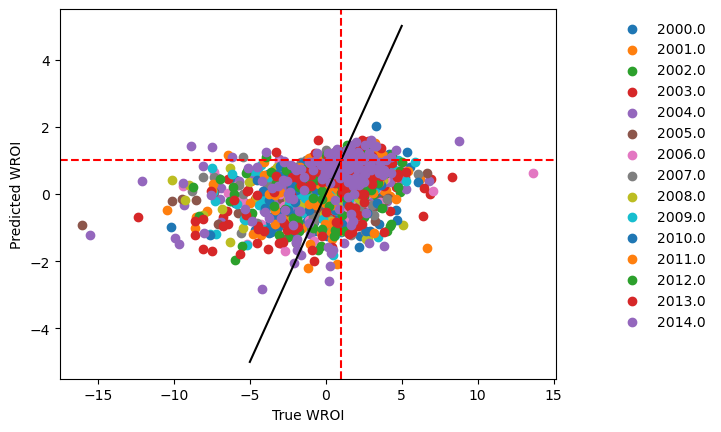

In [27]:
ks = np.arange(1, 50)
store_ks = []

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    val_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    val_predictors_scaled = scaler.transform(val_data[predictors].to_numpy())
    # Run regression
    coefs = np.zeros((len(ks), 4))
    for i in range(len(ks)):
        ## make lasso model
        neigh = KNeighborsRegressor(n_neighbors=ks[i]).fit(train_predictors_scaled, np.log2(train_data[outputs]))
        ## record coefs
        # Compute score
        val_prediction = neigh.predict(val_predictors_scaled)
        rmse = np.sqrt(mean_squared_error(np.log2(val_data[outputs]), val_prediction))
        score = neigh.score(val_predictors_scaled, np.log2(val_data[outputs]))
        coefs[i,3] = rmse
        coefs[i,2] = score
        coefs[i,1] = year
        coefs[i,0] = ks[i]

        # Visualize performance
        if i == len(ks) - 1:
            print("Year:", year, "RMSE:", rmse, "Score:", score)
    #  Store data
    store_ks.append(coefs)

# Model selection
## use dataframe to look at coefs
df = pd.DataFrame(data=np.vstack(store_ks), 
                  columns=['k', 'year','score', 'rmse']).groupby('k', as_index = True).mean()
opt_k = df.k.values[np.argmin(df.rmse.values)]

scaler = StandardScaler()
test_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())

neigh = KNeighborsRegressor(n_neighbors=opt_k).fit(train_predictors_scaled, np.log2(train_data[outputs]))
# Compute score
val_prediction = neigh.predict(val_predictors_scaled)

plt.scatter(np.log2(val_data[outputs]), val_prediction, label = str(year))
plt.plot(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.axhline(y = 1.0, linestyle = '--', color = 'red')
plt.axvline(x = 1.0, linestyle = '--', color = 'red')
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 1)

### Logistic regression

Year: 2000.0 Score: 0.6513157894736842
Year: 2001.0 Score: 0.588957055214724
Year: 2002.0 Score: 0.5208333333333334
Year: 2003.0 Score: 0.5641025641025641
Year: 2004.0 Score: 0.5888888888888889
Year: 2005.0 Score: 0.6073298429319371
Year: 2006.0 Score: 0.5614035087719298
Year: 2007.0 Score: 0.5364583333333334
Year: 2008.0 Score: 0.5231788079470199
Year: 2009.0 Score: 0.6256983240223464
Year: 2010.0 Score: 0.5355191256830601
Year: 2011.0 Score: 0.6139240506329114
Year: 2012.0 Score: 0.6153846153846154
Year: 2013.0 Score: 0.6171428571428571
Year: 2014.0 Score: 0.6514285714285715


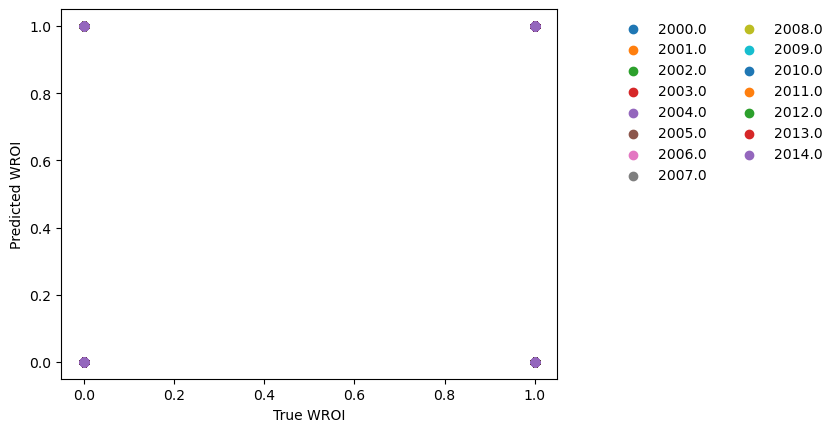

In [12]:
for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    val_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    val_predictors_scaled = scaler.transform(val_data[predictors].to_numpy())
    # Run regression
    clf = linear_model.LogisticRegression(random_state=0).fit(train_predictors_scaled,
                                                              train_data[outputs].values.ravel() >= 2)
    # Compute score
    val_prediction = clf.predict(val_predictors_scaled)
    print("Year:", year, "Score:", clf.score(val_predictors_scaled, val_data[outputs] >= 2))
    # Visualize performance
    plt.scatter(1*(val_data[outputs].values.ravel() >= 2), clf.predict(val_predictors_scaled), label = str(year))

plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 2)